In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahmedffarahat","key":"6aae4c6fe4972bda3351ee61c546bab4"}'}

In [3]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
lainguyn123/student-performance-factors                        Student Performance Factors                          94KB  2024-09-02 10:53:57          25175        449  1.0              
abdulszz/spotify-most-streamed-songs                           Spotify Most Streamed Songs                          60KB  2024-09-07 18:23:14           9109        116  1.0              
valakhorasani/mobile-device-usage-and-user-behavior-dataset    Mobile Device Usage and User Behavior Dataset        11KB  2024-09-28 20:21:12           2298         55  1.0              
asmonline/spotify-song-performance-dataset                     Sp

In [6]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 80% 65.0M/80.9M [00:00<00:00, 82.9MB/s]
100% 80.9M/80.9M [00:01<00:00, 79.0MB/s]


In [7]:
! mkdir train

In [8]:
! unzip /content/sentiment140.zip -d train

Archive:  /content/sentiment140.zip
  inflating: train/training.1600000.processed.noemoticon.csv  


In [1]:
!pip install keras-tuner

In [3]:
!pip install wordcloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from collections import Counter
from wordcloud import WordCloud

from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch

C:\Users\asamy\AppData\Local\Temp\ipykernel_13956\1705586254.py:24: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


In [2]:
import numpy as np
print(np.__version__)

1.23.5


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [1]:
import nltk
import os
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Step 1: Define and create NLTK data directory
nltk_data_dir = '/kaggle/working/nltk_data'
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Step 2: Download necessary NLTK data
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)
nltk.download('punkt', download_dir=nltk_data_dir)

# Step 3: Append the NLTK data directory to the NLTK path
nltk.data.path.append(nltk_data_dir)

# Step 4: Verify the download
from nltk.corpus import wordnet
synsets = wordnet.synsets('test')
print(f"Number of synsets found for 'test': {len(synsets)}")  # Should be > 0

# Step 5: Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Step 6: Sample DataFrame
data = {'cleaned_text': ['This is a test sentence.', 'Another test sentence here.']}
df = pd.DataFrame(data)

# Step 7: Define lemmatization function
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

# Step 8: Apply lemmatization
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

# Step 9: Display the DataFrame
print(df)


[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data] Downloading package punkt to /kaggle/working/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


Number of synsets found for 'test': 13
                  cleaned_text               lemmatized_text
0     This is a test sentence.     This is a test sentence .
1  Another test sentence here.  Another test sentence here .


In [13]:
columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

df = pd.read_csv('/content/train/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

In [14]:
print(df.head())
print(df.info())
print(df['polarity'].value_counts())

   polarity          id                          date     query  \
0         0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1         0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2         0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3         0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4         0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------  

In [15]:
df = df[df['polarity'] != 2]  # Drop neutral
df['sentiment'] = df['polarity'].map({0: 'negative', 4: 'positive'})

print(df['sentiment'].value_counts())


sentiment
negative    800000
positive    800000
Name: count, dtype: int64


In [16]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+|#', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip()
    return text

df['cleaned_text'] = df['text'].apply(clean_text)


In [17]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = word_tokenize(text.lower())
    filtered = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered)

df['cleaned_text'] = df['cleaned_text'].apply(remove_stopwords)

In [18]:

emoticon_dict = {
                    "🙂": "smiling",
                    "😂": "laughing",
                    "💔": "broken heart",
                    "❤️": "love",
                    "❤": "love",
                    "😍": "love",
                    "😭": "crying",
                    "😢": "sad",
                    "😔": "sad",
                    "♥": "love",
                    "💜": "love",
                    "😅": "laughing",
                    "🙁": "sad",
                    "💕": "love",
                    "💙": "love",
                    "😞": "sad",
                    "😊": "happy",
                    "👏": "clapping",
                    "👌": "well done",
                    "😴": "sleepy",
                    "😀": "laughing",
                    "😌": "content",
                    "🌹": "rose",
                    "🙈": "love",
                    "😄": "laughing",
                    "😐": "neutral",
                    "✌": "victorious",
                    "✨": "star",
                    "🤔": "thinking",
                    "😏": "smug",
                    "😒": "disappointed",
                    "🙄": "bored",
                    "😕": "nervous",
                    "😃": "laughing",
                    "🌸": "flower",
                    "😓": "sad",
                    "💞": "love",
                    "💗": "love",
                    "😑": "annoyed",
                    "💭": "thinking",
                    "😎": "confident",
                    "💛": "love",
                    "😩": "sad",
                    "💪": "strong",
                    "👍": "agree",
                    "🙏🏻": "please",
                    "😳": "shocked",
                    "👏🏼": "applause",
                    "🎶": "music",
                    "🌚": "silence",
                    "💚": "love",
                    "🙏": "please",
                    "💘": "love",
                    "🍃": "peace",
                    "☺": "laughing",
                    "🐸": "frog",
                    "😶": "shocked",
                    "✌️": "fun",
                    "✋🏻": "stop",
                    "😉": "wink",
                    "🌷": "love",
                    "🙃": "smiling",
                    "😫": "sad",
                    "😨": "shocked",
                    "🎼": "music",
                    "🍁": "fun",
                    "🍂": "fun",
                    "💟": "love",
                    "😪": "sad",
                    "😆": "laughing",
                    "😣": "frustrated",
                    "☺️": "love",
                    "😱": "disaster",
                    "😁": "laughing",
                    "😖": "frustrated",
                    "🏃🏼": "running",
                    "😡": "angry",
                    "🚶": "walking",
                    "🤕": "sick",
                    "‼️": "surprised",
                    "🕊": "bird",
                    "👌🏻": "well done",
                    "❣": "love",
                    "🙊": "shocked",
                    "💃": "happy, fun",
                    "💃🏼": "happy, fun",
                    "😜": "fun",
                    "👊": "punch",
                    "😟": "upset",
                    "💖": "love",
                    "😥": "sad",
                    "🎻": "music",
                    "✒": "writing",
                    "🚶🏻": "walking",
                    "💎": "diamond",
                    "😷": "sick",
                    "☝": "one",
                    "🚬": "smoking",
                    "💐": "flowers",
                    "🌞": "sun",
                    "👆": "first",
                    "⚠️": "warning",
                    "🤗": "hug",
                    "✖️": "wrong",
                    "📍": "location",
                    "👸": "queen",
                    "👑": "crown",
                    "✔️": "correct",
                    "💌": "heart",
                    "😲": "surprised",
                    "💦": "water",
                    "🚫": "wrong",
                    "👏🏻": "bravo",
                    "🏊": "swimming",
                    "👍🏻": "good",
                    "⭕️": "big circle",
                    "🎷": "saxophone",
                    "👋": "wave",
                    "✌🏼": "victory sign",
                    "🌝": "smiling",
                    "➿": "double knot",
                    "💪🏼": "strong",
                    "📩": "contact me",
                    "☕️": "coffee",
                    "😧": "worried",
                    "🗨": "message",
                    "❗️": "surprise",
                    "🙆🏻": "okay sign",
                    "👯": "friends",
                    "©": "symbol",
                    "👵🏽": "old woman",
                    "🐣": "chick",
                    "🙌": "encouraging",
                    "🙇": "bowing",
                    "👐🏽": "open hands",
                    "👌🏽": "exactly",
                    "⁉️": "exclamation",
                    "⚽️": "football",
                    "🕶": "love",
                    "🎈": "balloon",
                    "🎀": "bow",
                    "💵": "money",
                    "😋": "hungry",
                    "😛": "teasing",
                    "😠": "angry",
                    "✍🏻": "writing",
                    "🌾": "rice",
                    "👣": "footprints",
                    "❌": "rejected",
                    "🍟": "food",
                    "👬": "friendship",
                    "🐰": "bunny",
                    "☂": "rain",
                    "⚜": "fleur-de-lis",
                    "🐑": "sheep",
                    "🗣": "loud voice",
                    "👌🏼": "well done",
                    "☘": "fun",
                    "😮": "shock",
                    "😦": "worried",
                    "⭕": "correct",
                    "✏️": "pencil",
                    "ℹ": "information",
                    "🙍🏻": "refuse",
                    "⚪️": "purity",
                    "🐤": "sad",
                    "💫": "fun",
                    "💝": "love",
                    "🍔": "food",
                    "❤︎": "love",
                    "✈️": "travel",
                    "🏃🏻‍♀️": "running",
                    "🍳": "egg",
                    "🎤": "microphone",
                    "🎾": "ball",
                    "🐔": "chicken",
                    "🙋": "question",
                    "📮": "mail",
                    "💉": "medicine",
                    "🙏🏼": "please",
                    "💂🏿": "guard",
                    "🎬": "cinema",
                    "♦️": "fun",
                    "💡": "idea",
                    "‼": "surprise",
                    "👼": "baby",
                    "🔑": "key",
                    "♥️": "love",
                    "🕋": "Kaaba",
                    "🐓": "chicken",
                    "💩": "dislike",
                    "👽": "alien",
                    "☔️": "rain",
                    "🍷": "wine",
                    "🌟": "star",
                    "☁️": "clouds",
                    "👃": "disagree",
                    "🌺": "fun",
                    "🔪": "knife",
                    "♨": "heat",
                    "👊🏼": "punch",
                    "✏": "pencil",
                    "🚶🏾‍♀️": "walking",
                    "👊": "punch",
                    "◾️": "stop",
                    "😚": "love",
                    "🔸": "fun",
                    "👎🏻": "dislike",
                    "👊🏽": "punch",
                    "😙": "love",
                    "🎥": "filming",
                    "👉": "attention",
                    "👏🏽": "clapping",
                    "💪🏻": "muscles",
                    "🏴": "black flag",
                    "🔥": "fire",
                    "😬": "uncomfortable",
                    "👊🏿": "punch",
                    "🌿": "leaf",
                    "✋🏼": "hand stop",
                    "👐": "open hands",
                    "☠️": "scary face",
                    "🎉": "celebration",
                    "🔕": "silent",
                    "😿": "sad face",
                    "☹️": "hopeless",
                    "😘": "love",
                    "😰": "fear and sadness",
                    "🌼": "flower",
                    "💋": "kiss",
                    "👇": "down",
                    "❣️": "love",
                    "🎧": "headphones",
                    "📝": "writing",
                    "🍸": "drink",
                    "🙁": "sad"
}

def replace_emoticons(text, emoticon_dict):
    for emoticon, word in emoticon_dict.items():
        text = text.replace(emoticon, word)
    return text

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: replace_emoticons(text, emoticon_dict))

print(df['cleaned_text'])


0          awww thats bummer shoulda got david carr third...
1          upset cant update facebook texting might cry r...
2          dived many times ball managed save rest go bounds
3                           whole body feels itchy like fire
4                                   behaving im mad cant see
                                 ...                        
1599995                        woke school best feeling ever
1599996         thewdbcom cool hear old walt interviews â «
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999                                 happy charitytuesday
Name: cleaned_text, Length: 1600000, dtype: object


In [19]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: ' '.join([stemmer.stem(word) for word in text.split()]))

df['cleaned_text'] = df['cleaned_text'].apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in text.split()]))


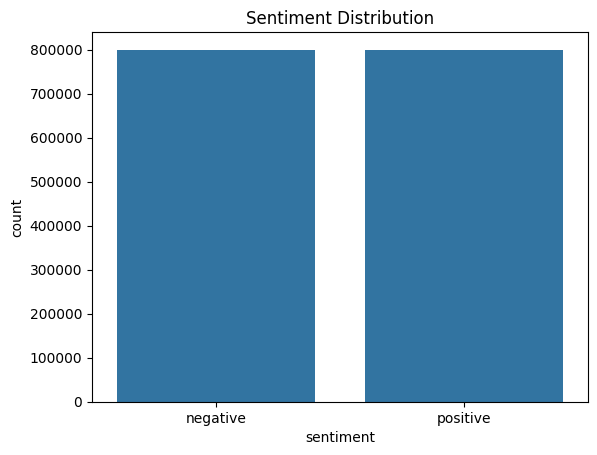

In [20]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

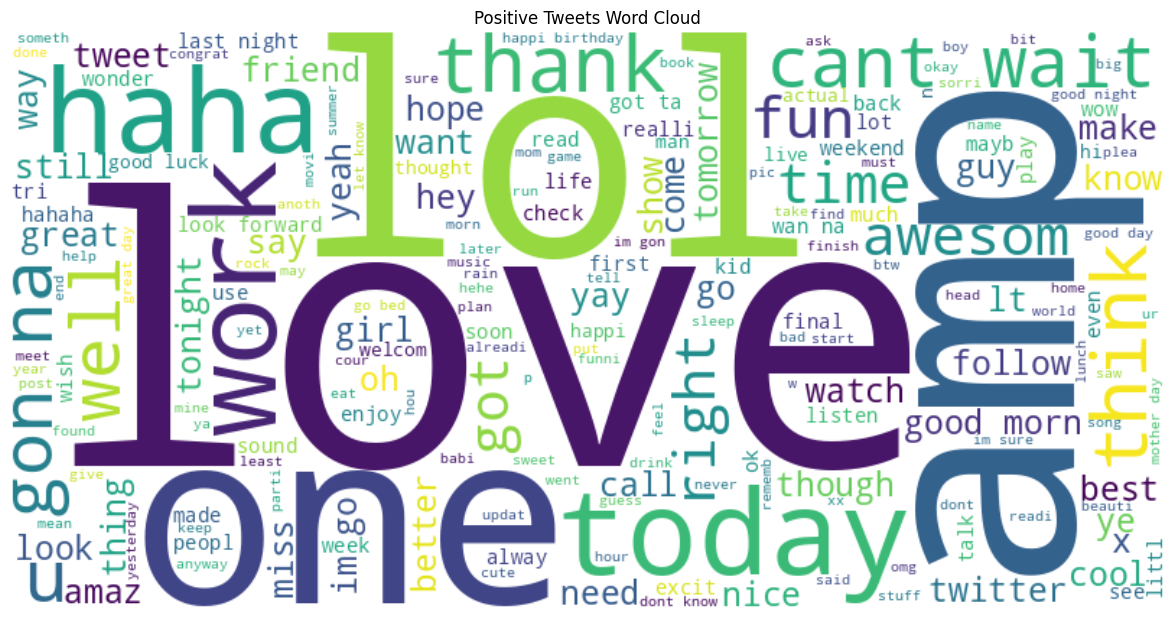

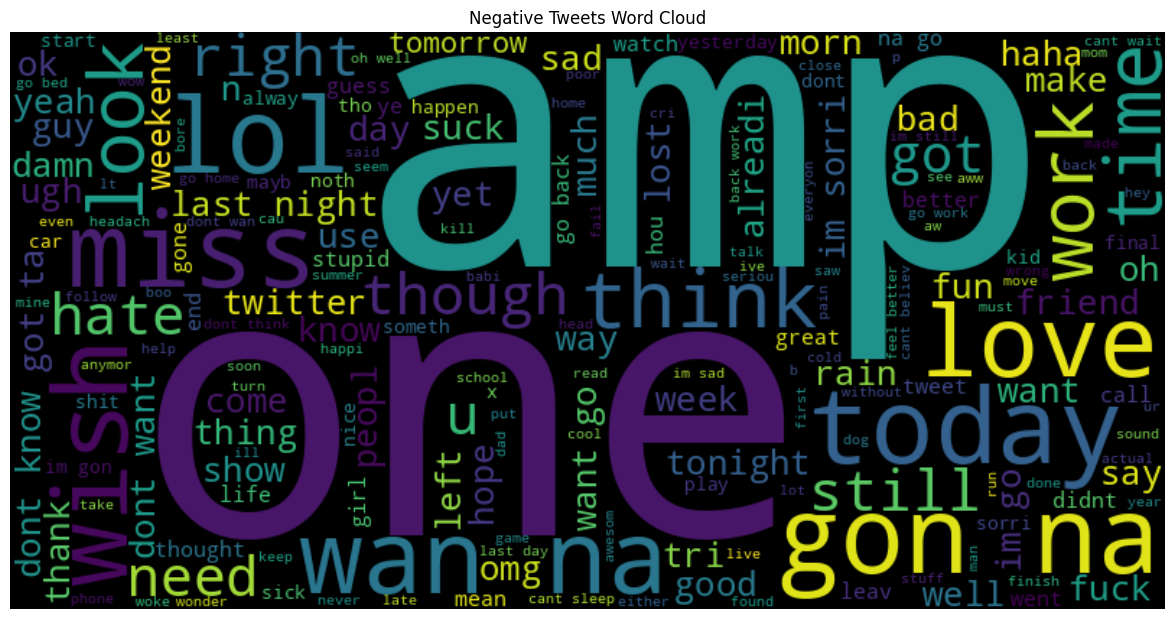

In [21]:
positive_text = ' '.join(df[df['sentiment'] == 'positive']['cleaned_text'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['cleaned_text'])

# Positive Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Tweets Word Cloud')
plt.show()

# Negative Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Tweets Word Cloud')
plt.show()


In [3]:
df = pd.read_csv("Filtered_data.csv")
df.dropna(inplace=True)

In [4]:
df.shape

(1592983, 8)

In [5]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

split_data = np.array_split(df_shuffled, 16)

df_part1 = split_data[0]
df_part2 = split_data[1]
df_part3 = split_data[2]
df_part4 = split_data[3]


C:\Users\asamy\anaconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [19]:
df_part1.to_csv("df_part1.csv" , index = False)
df_part2.to_csv("df_part2.csv" , index = False)
df_part3.to_csv("df_part3.csv" , index = False)
df_part4.to_csv("df_part4.csv" , index = False)

In [6]:
df = df_part1
df

,polarity,id,date,query,user,text,sentiment,cleaned_text
0,0,1835296397,Mon May 18 05:39:18 PDT 2009,NO_QUERY,TediousTishia,In second period doing absoultly nothing cuz o...,negative,second period absoultli noth cuz teacher gehhi...
1,0,1969933897,Sat May 30 01:47:20 PDT 2009,NO_QUERY,Dutchrudder,"Morning all,got Hemi's party 2day,gonna b bout...",negative,morn allgot hemi parti daygonna b bout kid run...
2,0,2071751324,Sun Jun 07 19:52:18 PDT 2009,NO_QUERY,Mrzv2da,@ONENONLYLO i was close,negative,close
3,4,1974608718,Sat May 30 13:28:59 PDT 2009,NO_QUERY,pandajen,@prpl646 and @deaddoll agreed! dance that nast...,positive,agre danc nasti hangov away
4,0,2176334573,Mon Jun 15 03:35:20 PDT 2009,NO_QUERY,WhatIfImAnOcean,Too early in the morning. Why do I always have...,negative,earli morn alway wake im good dream
...,...,...,...,...,...,...,...,...
99557,4,2175288568,Mon Jun 15 00:34:44 PDT 2009,NO_QUERY,mattcharlton,@notmywords yep I got you last night,positive,yep got last night
99558,4,1981660371,Sun May 31 09:37:32 PDT 2009,NO_QUERY,techpinas,@daveascott Thank you so much for the quote. I...,positive,thank much quot realli appreci
99559,4,2185489496,Mon Jun 15 17:27:34 PDT 2009,NO_QUERY,Stacefacemagace,@brsecrist Brian you are the only one that mat...,positive,brian one matter figur tech question knew hope...
99560,0,2045106338,Fri Jun 05 10:14:46 PDT 2009,NO_QUERY,Eyvana,@bridget_may my mom has my phone so that i stu...,negative,mom phone studi sat bio test tommorow ill call...


In [7]:
df.isnull().sum()

polarity        0
id              0
date            0
query           0
user            0
text            0
sentiment       0
cleaned_text    0
dtype: int64

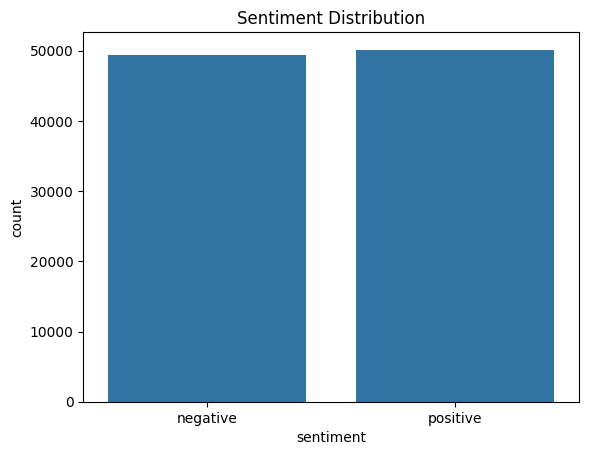

In [9]:
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.show()

In [10]:
def get_most_common_words(texts, num=20):
    words = ' '.join(texts).split()
    counter = Counter(words)
    return counter.most_common(num)

print("Most common words in positive tweets:")
print(get_most_common_words(df[df['sentiment'] == 'positive']['cleaned_text']))

print("\nMost common words in negative tweets:")
print(get_most_common_words(df[df['sentiment'] == 'negative']['cleaned_text']))


Most common words in positive tweets:
[('im', 4590), ('love', 3893), ('good', 3859), ('go', 3698), ('day', 3485), ('thank', 3159), ('get', 3072), ('like', 2509), ('u', 2322), ('lol', 2126), ('time', 2107), ('got', 2019), ('work', 1844), ('today', 1818), ('know', 1758), ('see', 1747), ('one', 1744), ('watch', 1655), ('new', 1630), ('great', 1566)]

Most common words in negative tweets:
[('im', 6574), ('go', 4883), ('get', 3821), ('work', 3624), ('day', 3104), ('miss', 2978), ('cant', 2787), ('dont', 2748), ('like', 2578), ('got', 2446), ('want', 2444), ('today', 2332), ('feel', 2257), ('back', 2000), ('realli', 1944), ('time', 1897), ('u', 1822), ('one', 1796), ('sad', 1781), ('still', 1771)]


In [15]:
X = df['cleaned_text']
y = df['sentiment']

# # Encode labels
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y = le.fit_transform(y)  # positive:1, negative:0

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))  # Using unigrams and bigrams
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

In [16]:
# # Define parameters
# max_words = 10000
# max_len = 100

# tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
# tokenizer.fit_on_texts(X_train)

# # Convert texts to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# # Pad sequences
# X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
# X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

In [13]:
# class SentimentHyperModel(HyperModel):
#     def __init__(self, max_words, max_len):
#         self.max_words = max_words
#         self.max_len = max_len

#     def build(self, hp):
#         model = Sequential()
#         model.add(Embedding(input_dim=self.max_words,
#                             output_dim=hp.Int('embedding_dim', min_value=64, max_value=256, step=64),
#                             input_length=self.max_len))
#         model.add(LSTM(units=hp.Int('lstm_units', min_value=64, max_value=256, step=64),
#                        dropout=hp.Float('dropout', 0.2, 0.5, step=0.1),
#                        recurrent_dropout=hp.Float('recurrent_dropout', 0.2, 0.5, step=0.1)))
#         model.add(Dense(1, activation='sigmoid'))

#         model.compile(loss='binary_crossentropy',
#                       optimizer=tf.keras.optimizers.Adam(
#                           hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
#                       metrics=['accuracy'])
#         return model

# # Initialize HyperModel and Tuner
# hypermodel = SentimentHyperModel(max_words, max_len)

# tuner = RandomSearch(
#     hypermodel,
#     objective='val_accuracy',
#     max_trials=5,
#     executions_per_trial=3,
#     directory='sentiment_tuning',
#     project_name='sentiment_analysis'
# )

# # Perform the search, adding batch_size parameter
# tuner.search(X_train_padded, y_train, 
#              epochs=5, 
#              validation_data=(X_test_padded, y_test), 
#              batch_size=128)

# # Get the best model and hyperparameters
# best_model = tuner.get_best_models(num_models=1)[0]
# best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# print(best_hyperparameters.values)



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
192               |192               |embedding_dim
192               |192               |lstm_units
0.4               |0.4               |dropout
0.2               |0.2               |recurrent_dropout
0.001             |0.001             |learning_rate

Epoch 1/5
 499/2490 [=====>........................] - ETA: 23:38 - loss: 0.0048 - accuracy: 1.0000

KeyboardInterrupt: 

In [17]:
# embedding_dim = 100  
# glove_path = r"C:\Users\asamy\anaconda3\Projects\DEPI_Final_Project\Sentiment140\glove.6B\glove.6B.100d.txt"  

# embedding_index = {}
# with open(glove_path, 'r', encoding='utf-8') as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embedding_index[word] = coefs

# word_index = tokenizer.word_index
# embedding_matrix = np.zeros((max_words, embedding_dim))

# for word, i in word_index.items():
#     if i < max_words:
#         embedding_vector = embedding_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector

In [18]:
# model = Sequential([
#     Embedding(input_dim=max_words, output_dim=embedding_dim, 
#               input_length=max_len, 
#               weights=[embedding_matrix], 
#               trainable=False),  
#     LSTM(128, dropout=0.2, recurrent_dropout=0.2),
#     Dense(1, activation='sigmoid')
# ])


In [20]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# history = model.fit(X_train_padded, y_train,
#                     epochs=20,
#                     batch_size=64,
#                     validation_data=(X_test_padded, y_test))


Epoch 1/20
200/200 [==============================] - 115s 563ms/step - loss: 0.6931 - accuracy: 0.5078 - val_loss: 0.6934 - val_accuracy: 0.4965
Epoch 2/20
200/200 [==============================] - 110s 549ms/step - loss: 0.6931 - accuracy: 0.5059 - val_loss: 0.6933 - val_accuracy: 0.4965
Epoch 3/20
200/200 [==============================] - 112s 560ms/step - loss: 0.6932 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 4/20
200/200 [==============================] - 112s 560ms/step - loss: 0.6932 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 5/20
200/200 [==============================] - 113s 565ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6933 - val_accuracy: 0.4965
Epoch 6/20
200/200 [==============================] - 113s 565ms/step - loss: 0.6932 - accuracy: 0.5067 - val_loss: 0.6937 - val_accuracy: 0.4965
Epoch 7/20
200/200 [==============================] - 112s 562ms/step - loss: 0.6933 - accuracy: 0.5054 - val_loss: 0.6933 -

KeyboardInterrupt: 

In [26]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

In [24]:
le = LabelEncoder()
y = le.fit_transform(y)  # Encode positive: 1, negative: 0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [25]:
max_words = 10000  # Maximum number of words in the vocabulary
max_len = 100  # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences to ensure uniform input size
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


In [27]:
embedding_dim = 100
glove_path = r"C:\Users\asamy\anaconda3\Projects\DEPI_Final_Project\Sentiment140\glove.6B\glove.6B.100d.txt" # Path to GloVe embeddings (download as explained earlier)

# Load GloVe word vectors into a dictionary
embedding_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Build the Bidirectional LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, 
              input_length=max_len, 
              weights=[embedding_matrix], 
              trainable=True),  
    Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________


In [28]:
tf.keras.backend.clear_session()

In [30]:
from sklearn.utils import class_weight

# Compute class weights to handle imbalanced data
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_train), 
                                                  y=y_train)

# Convert class weights into a dictionary
class_weights_dict = dict(enumerate(class_weights))

# Train the model with class weights
history = model.fit(X_train_padded, y_train,
                    epochs=20,  # Increase epochs for better training
                    batch_size=128,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights_dict)  # Pass class weights dictionary


Epoch 1/20
100/100 [==============================] - 131s 1s/step - loss: 0.6327 - accuracy: 0.6404 - val_loss: 0.5812 - val_accuracy: 0.6993
Epoch 2/20
100/100 [==============================] - 122s 1s/step - loss: 0.5449 - accuracy: 0.7330 - val_loss: 0.5548 - val_accuracy: 0.7128
Epoch 3/20
100/100 [==============================] - 121s 1s/step - loss: 0.4855 - accuracy: 0.7714 - val_loss: 0.5363 - val_accuracy: 0.7213
Epoch 4/20
100/100 [==============================] - 121s 1s/step - loss: 0.4340 - accuracy: 0.8023 - val_loss: 0.5566 - val_accuracy: 0.7147
Epoch 5/20
100/100 [==============================] - 127s 1s/step - loss: 0.3944 - accuracy: 0.8238 - val_loss: 0.5554 - val_accuracy: 0.7241
Epoch 6/20
100/100 [==============================] - 127s 1s/step - loss: 0.3531 - accuracy: 0.8453 - val_loss: 0.5801 - val_accuracy: 0.7141
Epoch 7/20
100/100 [==============================] - 127s 1s/step - loss: 0.3144 - accuracy: 0.8669 - val_loss: 0.6319 - val_accuracy: 0.7100

In [31]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

100/100 [==============================] - 11s 111ms/step - loss: 1.4226 - accuracy: 0.6915
Test Accuracy: 69.15%


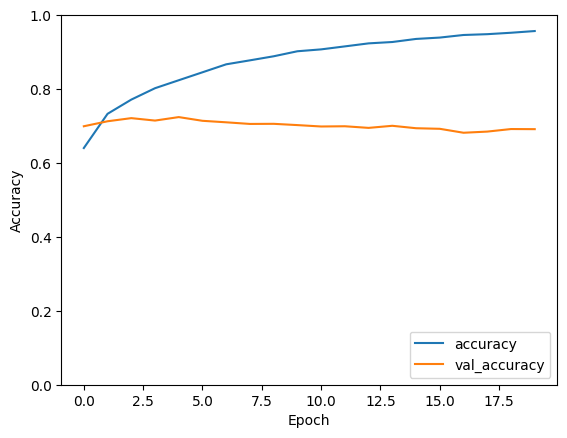

In [32]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [33]:
loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f'LSTM Test Accuracy: {accuracy*100:.2f}%')

100/100 [==============================] - 11s 107ms/step - loss: 1.4226 - accuracy: 0.6915
LSTM Test Accuracy: 69.15%


In [34]:
y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype("int32")

from sklearn.metrics import classification_report, confusion_matrix

print("LSTM Classification Report:")
print(classification_report(y_test, y_pred_lstm))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lstm))


100/100 [==============================] - 15s 150ms/step
LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1604
           1       0.67      0.74      0.70      1582

    accuracy                           0.69      3186
   macro avg       0.69      0.69      0.69      3186
weighted avg       0.69      0.69      0.69      3186

Confusion Matrix:
[[1037  567]
 [ 416 1166]]


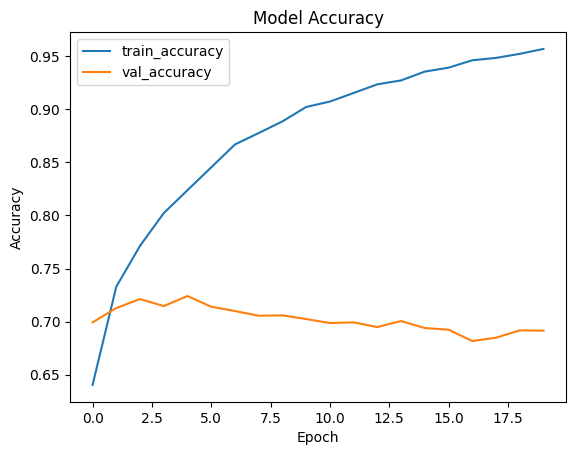

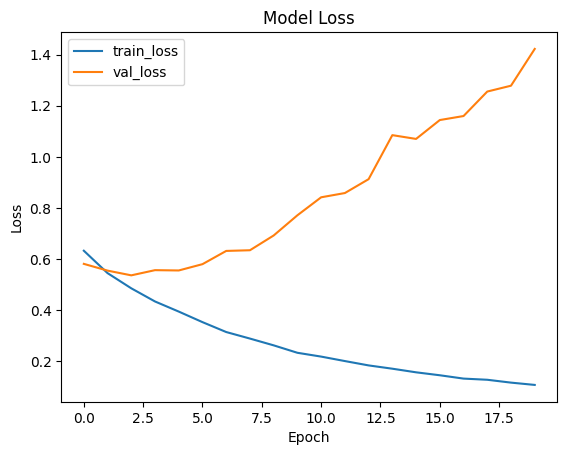

In [35]:
# Accuracy Plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


100/100 [==============================] - 12s 121ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.65      0.68      1604
           1       0.67      0.74      0.70      1582

    accuracy                           0.69      3186
   macro avg       0.69      0.69      0.69      3186
weighted avg       0.69      0.69      0.69      3186



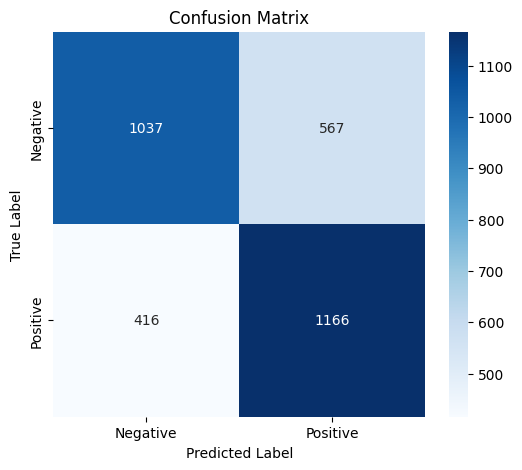

In [37]:
y_pred = model.predict(X_test_padded)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [38]:
import pickle

# Save the tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [39]:
model.save('sentiment_model.h5')


In [ ]:
import re
import pickle
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Preprocessing function
def preprocess_input_text(text, max_len=100):
    # Define stopwords, stemmer, and lemmatizer
    stop_words = set(stopwords.words('english'))
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Replace emoticons (use your emoticon dictionary)

emoticon_dict = {
                    "🙂": "smiling",
                    "😂": "laughing",
                    "💔": "broken heart",
                    "❤️": "love",
                    "❤": "love",
                    "😍": "love",
                    "😭": "crying",
                    "😢": "sad",
                    "😔": "sad",
                    "♥": "love",
                    "💜": "love",
                    "😅": "laughing",
                    "🙁": "sad",
                    "💕": "love",
                    "💙": "love",
                    "😞": "sad",
                    "😊": "happy",
                    "👏": "clapping",
                    "👌": "well done",
                    "😴": "sleepy",
                    "😀": "laughing",
                    "😌": "content",
                    "🌹": "rose",
                    "🙈": "love",
                    "😄": "laughing",
                    "😐": "neutral",
                    "✌": "victorious",
                    "✨": "star",
                    "🤔": "thinking",
                    "😏": "smug",
                    "😒": "disappointed",
                    "🙄": "bored",
                    "😕": "nervous",
                    "😃": "laughing",
                    "🌸": "flower",
                    "😓": "sad",
                    "💞": "love",
                    "💗": "love",
                    "😑": "annoyed",
                    "💭": "thinking",
                    "😎": "confident",
                    "💛": "love",
                    "😩": "sad",
                    "💪": "strong",
                    "👍": "agree",
                    "🙏🏻": "please",
                    "😳": "shocked",
                    "👏🏼": "applause",
                    "🎶": "music",
                    "🌚": "silence",
                    "💚": "love",
                    "🙏": "please",
                    "💘": "love",
                    "🍃": "peace",
                    "☺": "laughing",
                    "🐸": "frog",
                    "😶": "shocked",
                    "✌️": "fun",
                    "✋🏻": "stop",
                    "😉": "wink",
                    "🌷": "love",
                    "🙃": "smiling",
                    "😫": "sad",
                    "😨": "shocked",
                    "🎼": "music",
                    "🍁": "fun",
                    "🍂": "fun",
                    "💟": "love",
                    "😪": "sad",
                    "😆": "laughing",
                    "😣": "frustrated",
                    "☺️": "love",
                    "😱": "disaster",
                    "😁": "laughing",
                    "😖": "frustrated",
                    "🏃🏼": "running",
                    "😡": "angry",
                    "🚶": "walking",
                    "🤕": "sick",
                    "‼️": "surprised",
                    "🕊": "bird",
                    "👌🏻": "well done",
                    "❣": "love",
                    "🙊": "shocked",
                    "💃": "happy, fun",
                    "💃🏼": "happy, fun",
                    "😜": "fun",
                    "👊": "punch",
                    "😟": "upset",
                    "💖": "love",
                    "😥": "sad",
                    "🎻": "music",
                    "✒": "writing",
                    "🚶🏻": "walking",
                    "💎": "diamond",
                    "😷": "sick",
                    "☝": "one",
                    "🚬": "smoking",
                    "💐": "flowers",
                    "🌞": "sun",
                    "👆": "first",
                    "⚠️": "warning",
                    "🤗": "hug",
                    "✖️": "wrong",
                    "📍": "location",
                    "👸": "queen",
                    "👑": "crown",
                    "✔️": "correct",
                    "💌": "heart",
                    "😲": "surprised",
                    "💦": "water",
                    "🚫": "wrong",
                    "👏🏻": "bravo",
                    "🏊": "swimming",
                    "👍🏻": "good",
                    "⭕️": "big circle",
                    "🎷": "saxophone",
                    "👋": "wave",
                    "✌🏼": "victory sign",
                    "🌝": "smiling",
                    "➿": "double knot",
                    "💪🏼": "strong",
                    "📩": "contact me",
                    "☕️": "coffee",
                    "😧": "worried",
                    "🗨": "message",
                    "❗️": "surprise",
                    "🙆🏻": "okay sign",
                    "👯": "friends",
                    "©": "symbol",
                    "👵🏽": "old woman",
                    "🐣": "chick",
                    "🙌": "encouraging",
                    "🙇": "bowing",
                    "👐🏽": "open hands",
                    "👌🏽": "exactly",
                    "⁉️": "exclamation",
                    "⚽️": "football",
                    "🕶": "love",
                    "🎈": "balloon",
                    "🎀": "bow",
                    "💵": "money",
                    "😋": "hungry",
                    "😛": "teasing",
                    "😠": "angry",
                    "✍🏻": "writing",
                    "🌾": "rice",
                    "👣": "footprints",
                    "❌": "rejected",
                    "🍟": "food",
                    "👬": "friendship",
                    "🐰": "bunny",
                    "☂": "rain",
                    "⚜": "fleur-de-lis",
                    "🐑": "sheep",
                    "🗣": "loud voice",
                    "👌🏼": "well done",
                    "☘": "fun",
                    "😮": "shock",
                    "😦": "worried",
                    "⭕": "correct",
                    "✏️": "pencil",
                    "ℹ": "information",
                    "🙍🏻": "refuse",
                    "⚪️": "purity",
                    "🐤": "sad",
                    "💫": "fun",
                    "💝": "love",
                    "🍔": "food",
                    "❤︎": "love",
                    "✈️": "travel",
                    "🏃🏻‍♀️": "running",
                    "🍳": "egg",
                    "🎤": "microphone",
                    "🎾": "ball",
                    "🐔": "chicken",
                    "🙋": "question",
                    "📮": "mail",
                    "💉": "medicine",
                    "🙏🏼": "please",
                    "💂🏿": "guard",
                    "🎬": "cinema",
                    "♦️": "fun",
                    "💡": "idea",
                    "‼": "surprise",
                    "👼": "baby",
                    "🔑": "key",
                    "♥️": "love",
                    "🕋": "Kaaba",
                    "🐓": "chicken",
                    "💩": "dislike",
                    "👽": "alien",
                    "☔️": "rain",
                    "🍷": "wine",
                    "🌟": "star",
                    "☁️": "clouds",
                    "👃": "disagree",
                    "🌺": "fun",
                    "🔪": "knife",
                    "♨": "heat",
                    "👊🏼": "punch",
                    "✏": "pencil",
                    "🚶🏾‍♀️": "walking",
                    "👊": "punch",
                    "◾️": "stop",
                    "😚": "love",
                    "🔸": "fun",
                    "👎🏻": "dislike",
                    "👊🏽": "punch",
                    "😙": "love",
                    "🎥": "filming",
                    "👉": "attention",
                    "👏🏽": "clapping",
                    "💪🏻": "muscles",
                    "🏴": "black flag",
                    "🔥": "fire",
                    "😬": "uncomfortable",
                    "👊🏿": "punch",
                    "🌿": "leaf",
                    "✋🏼": "hand stop",
                    "👐": "open hands",
                    "☠️": "scary face",
                    "🎉": "celebration",
                    "🔕": "silent",
                    "😿": "sad face",
                    "☹️": "hopeless",
                    "😘": "love",
                    "😰": "fear and sadness",
                    "🌼": "flower",
                    "💋": "kiss",
                    "👇": "down",
                    "❣️": "love",
                    "🎧": "headphones",
                    "📝": "writing",
                    "🍸": "drink",
                    "🙁": "sad"
}

    for emoticon, word in emoticon_dict.items():
        text = text.replace(emoticon, word)
    
    # Lowercasing, removing links, special characters, and numbers
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    
    # Tokenization and stemming/lemmatization
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [stemmer.stem(word) for word in words]  # Apply stemming
    words = [lemmatizer.lemmatize(word) for word in words]  # Apply lemmatization
    cleaned_text = ' '.join(words)
    
    # Convert text to sequences and pad
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    return padded_seq


In [13]:
import dagshub
dagshub.init(repo_owner='asamy4194', repo_name='DEPI_Final_Project', mlflow=True)


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

C:\Users\asamy\anaconda3\envs\tf\lib\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d05f7d59-7960-4205-ace3-07d494552f87&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=77879bfde2d2ce7fc948195aeeb9bd4c7043773721ccc26106d75c969be4c53d




Accessing as asamy4194

Initialized MLflow to track repo "asamy4194/DEPI_Final_Project"

Repository asamy4194/DEPI_Final_Project initialized!

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from collections import Counter
from wordcloud import WordCloud

# MLflow imports
import mlflow
import mlflow.keras
import mlflow.tensorflow
import os

glove_path = r"C:\Users\asamy\anaconda3\Projects\DEPI_Final_Project\Sentiment140\glove.6B\glove.6B.100d.txt"

# Initialize MLflow Experiment
mlflow.set_experiment("Sentiment Analysis - Bidirectional LSTM")
# Optionally set tracking URI if using remote server
mlflow.set_tracking_uri("https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow")

with mlflow.start_run(run_name="Bidirectional_LSTM_Run"):
    # ========================
    # 1. Data Preprocessing
    # ========================
    
    # Assuming X and y are already defined as your features and labels
    # Example:
    # X = df['text_column']
    # y = df['label_column']
    
    le = LabelEncoder()
    y = le.fit_transform(y)  # Encode positive: 1, negative: 0
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Parameters
    max_words = 10000  # Maximum number of words in the vocabulary
    max_len = 100      # Maximum sequence length
    embedding_dim = 100
    lstm_units = 128
    dropout_rate = 0.2
    recurrent_dropout_rate = 0.2
    batch_size = 128
    epochs = 20
    optimizer = 'adam'
    loss = 'binary_crossentropy'
    metrics = ['accuracy']
    
    # Log parameters to MLflow
    params = {
        "max_words": max_words,
        "max_len": max_len,
        "embedding_dim": embedding_dim,
        "lstm_units": lstm_units,
        "dropout_rate": dropout_rate,
        "recurrent_dropout_rate": recurrent_dropout_rate,
        "batch_size": batch_size,
        "epochs": epochs,
        "optimizer": optimizer,
        "loss": loss,
        "metrics": metrics,
        "glove_path": glove_path  # Ensure glove_path is defined or logged separately
    }
    mlflow.log_params(params)
    
    # Tokenization and Padding
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    X_train_padded = pad_sequences(
        X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_padded = pad_sequences(
        X_test_seq, maxlen=max_len, padding='post', truncating='post')
    
    # Load GloVe embeddings
    glove_path = r"C:\Users\asamy\anaconda3\Projects\DEPI_Final_Project\Sentiment140\glove.6B\glove.6B.100d.txt"
    embedding_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    
    # ========================
    # 2. Model Building
    # ========================
    
    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, 
                  input_length=max_len, 
                  weights=[embedding_matrix], 
                  trainable=True),
        Bidirectional(LSTM(lstm_units, dropout=dropout_rate, 
                           recurrent_dropout=recurrent_dropout_rate)),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    # Compile the model
    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    
    # Log model architecture
    model.summary()
    
    # ========================
    # 3. Training
    # ========================
    
    # Clear any previous sessions
    tf.keras.backend.clear_session()
    
    # Compute class weights to handle imbalanced data
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced', 
        classes=np.unique(y_train), 
        y=y_train
    )
    class_weights_dict = dict(enumerate(class_weights))
    
    # Log class weights
    mlflow.log_param("class_weights", class_weights_dict)
    
    # Early Stopping Callback
    early_stopping = EarlyStopping(monitor='val_accuracy', 
                                   patience=5, 
                                   restore_best_weights=True)
    
    # Train the model
    history = model.fit(
        X_train_padded, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_padded, y_test),
        class_weight=class_weights_dict,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # ========================
    # 4. Evaluation
    # ========================
    
    loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
    print(f"LSTM Test Accuracy: {accuracy * 100:.2f}%")
    
    # Log evaluation metrics
    mlflow.log_metrics({
        "test_loss": loss,
        "test_accuracy": accuracy
    })
    
    # Predictions
    y_pred_lstm = (model.predict(X_test_padded) > 0.5).astype("int32")
    
    # Classification Report
    report = classification_report(y_test, y_pred_lstm, output_dict=True)
    print("LSTM Classification Report:")
    print(classification_report(y_test, y_pred_lstm))
    
    # Log classification report metrics
    mlflow.log_metrics({
        "precision_class_0": report['0']['precision'],
        "recall_class_0": report['0']['recall'],
        "f1_score_class_0": report['0']['f1-score'],
        "precision_class_1": report['1']['precision'],
        "recall_class_1": report['1']['recall'],
        "f1_score_class_1": report['1']['f1-score'],
        "precision_macro": report['macro avg']['precision'],
        "recall_macro": report['macro avg']['recall'],
        "f1_score_macro": report['macro avg']['f1-score'],
        "accuracy": report['accuracy']
    })
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_lstm)
    print("Confusion Matrix:")
    print(cm)
    
    # ========================
    # 5. Plotting and Logging Artifacts
    # ========================
    
    # Create a directory to save plots
    artifacts_dir = "mlflow_artifacts"
    os.makedirs(artifacts_dir, exist_ok=True)
    
    # Accuracy Plot
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    accuracy_plot_path = os.path.join(artifacts_dir, "accuracy_plot.png")
    plt.savefig(accuracy_plot_path)
    plt.close()
    
    # Loss Plot
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    loss_plot_path = os.path.join(artifacts_dir, "loss_plot.png")
    plt.savefig(loss_plot_path)
    plt.close()
    
    # Confusion Matrix Plot
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['Negative', 'Positive'], 
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    cm_plot_path = os.path.join(artifacts_dir, "confusion_matrix.png")
    plt.savefig(cm_plot_path)
    plt.close()
    
    # Log artifacts to MLflow
    mlflow.log_artifacts(artifacts_dir)
    
    # ========================
    # 6. Log the Model
    # ========================
    
    mlflow.keras.log_model(model, "model")
    
    # Optionally, log the tokenizer if needed for inference
    import pickle
    tokenizer_path = os.path.join(artifacts_dir, "tokenizer.pkl")
    with open(tokenizer_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    mlflow.log_artifact(tokenizer_path)
    
    # Clean up artifacts directory if desired
    # import shutil
    # shutil.rmtree(artifacts_dir)
    
# End of MLflow run


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
623/623 [==============================] - 759s 1s/step - loss: 0.5454 - accuracy: 0.7203 - val_loss: 0.4880 - val_accuracy: 0.7673
Epoch 2/20
623/623 [==============================] - 756s 1s/step - loss: 0.4742 - accuracy: 0.7726 

2024/10/16 23:47:17 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\asamy\AppData\Local\Temp\tmp0be7_t5y\model\data\model\assets


2024/10/16 23:47:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/16 23:48:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run Bidirectional_LSTM_Run at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/0/runs/c1dd5252568d4b3ea66ea250613db362.
2024/10/16 23:48:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/asamy4194/DEPI_Final_Project.mlflow/#/experiments/0.
